# Proiect Congestion Control

Se cere implementarea unui algorim de congestion control care sa maximizeze rata de transmisie (throughput), fairness-ul si sa minimizeze latenta.  Puteti dezvolta propriul vostru algoritm (chiar si cu ML),
sau puteti implementa unul dintre algoritmii existenti precum [TCP Cubic](https://www.cs.princeton.edu/courses/archive/fall16/cos561/papers/Cubic08.pdf), Tahoe, etc. Fiecare echipa trebuie sa selecteze un algoritm de congestion control pe care doreste sa il implementeze. Puteti alege orice algoritm doriti sa implementati; o lista de algoritmi o puteti gasit aici: https://en.wikipedia.org/wiki/TCP_congestion_control. Va sugeram insa sa alegeti un algoritm care se poate implementa doar la endhosts, si nu necesita sprijin aditional in retea (de exemplu ECN marking). O lista posibila de astfel de algoritmi, impreuna cu descrierea lor detaliata, este urmatoarea. Va recomandam sa parcurgeti articolul stintific aferent algoritmului inainte de a va apuca de implementare. Va recomandam Google Scholar pentru a il gasi. De asemenea, va puteti consulta la curs cu Costin.

Implementarea o vom face in simulatorul HTsim. Vom lucra in fisierul `cc.cpp`, unde gasim o implementare de cod de sender/receiver. In mare vom lucra in functile `onACK()` si `onLoss()`. Topologia este de tip dumbell, unde avem mai multi hosti care transmit date peste acelasi link care ajunge sa fie un bottleneck catre un sink (receiver).

> Vom considera MSS = 1500 bytes

**Lectura recomandata:**

  - [Network Congestion - pana la 17 (20 min)](https://www.youtube.com/watch?v=4-KPHk-dZ1M&list=PLAwxTw4SYaPlEHG2kkN5Kl1eKHeZuJDG-&index=3)
  - [Congestion control](https://beta.computer-networking.info/syllabus/default/protocols/congestion.html)



### Inainte de a rula simulatorul

Vom folosi matplotlib pentru a realiza graficele. Rezultatele rularii simulatorului se vor gasi in directorul `tmp`.

In [21]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [22]:
# Note: comenzile prefixate cu ! sunt rulate in Bash, nu in Python!
!mkdir -p tmp/t

In [23]:
# O sa intalnim des apelul functiei format pe un string. Aceasta este similara cu %s sau %d in printf.

string = "ceva{}".format(4)
print(string)

ceva4


### Cod pentru desenarea graficelor

In [24]:
import matplotlib.pyplot as plt

# Fiecare fisier .dat dim tmp contine date despre o conexiune. Acestea au urmatorul format:
# 0.100000000 Type CC_SINK ID 0 Ev RATE CAck 3643500 CWND 1776791 Rate 36435000
# De exemplu la indexul 0 se afla timestamp-ul, iar la indexul 12 throughput-ul

def plot_generic(axs, index_f1, index_f2, ylabel, xlabel, scale_y, num_cons, data_folder="tmp/t/"):
    for i in range(num_cons):
        x1, y1 = [], []
        # Citeste throughput-ul din fisierul aferent conexiunii i
        with open("{}{}.dat".format(data_folder, i)) as f:
            for line in f:
                values = line.split()
                x1.append(float(values[index_f1]))
                y1.append(float(values[index_f2]) * scale_y)
        axs.plot(x1, y1, '-', label='Conn {}'.format(i))
        axs.legend()
    
def plot_throughput(axs, num_cons):
    axs.set_ylabel('Throughput (Mbps)')
    axs.set_xlabel('Time (s)')
    # Valorile din fisieri sunt in byes asa ca le inmultim cu 8/1000000 ca sa trecem in Mb/s
    plot_generic(axs, 0, 12, 'Throughput', 'Time (s)', 8 / 1000000, num_cons)

def plot_cwnd(axs, num_cons):
    axs.set_ylabel('CWND (MSS)')
    axs.set_xlabel('Time (s)')
    plot_generic(axs, 0, 10, 'CWND (MSS)', 'Time (s)', 1/1500, num_cons)

def plot_router_queue(axs, max_queue_size, data_folder="tmp/t/"):
    axs.set_ylabel('Packets in Queue (MSS) ')
    axs.set_xlabel('Time (s)')
    x1, y1 = [], []
    with open("{}q.dat".format(data_folder)) as f:
        for line in f:
            values = line.split()
            x1.append(float(values[0]))
            y1.append(float(values[12]) * 1/1500)
        
        axs.hlines(y=max_queue_size, xmin=0, xmax=x1[-1], linewidth=2, color='r')
        axs.plot(x1, y1, '-')    

### Masurarea performantei algoritmului de congestion control

Urmatoarele celule compileaza si ruleaza simulatorul. Ulterior vom folosii functile definite in sectiunile precedente pentru a realiza graficele valorilor CWND, viteza de transmisie, fairness, coada de pachete din router etc. Acestea ne vor ajuta in a intelege performanta protocolului nostru.

In [25]:
# Inainte de a rula o simulare, vom chema make
!make -s

# Rulam simulatorul (vezi main_dumbell_cc.cpp)
# -cons numarul de conexiuni
# -end (ms) timpul de rulare al experimentului
# -latency (ms) latenta link-urilor
# -q dimensiunea cozii in MSS
# -startdelta (ms) de la ce timp sa porneasca o noua conexiune
# -log (ms) intervalul la care se fac masuratori pentrum cwnd
# -bandwidth (mbps) seteaza bandwidth-ul linkurilor
num_cons = 3
router_queue_size = 800
# Rulam simulatorul din bash. ./scripts/parse.sh logout.dat parseaza rezultatele si le scrie in format human readable in folder-ul 
! ./htsim_dumbell_cc -conns {num_cons} -end 20000 -log 100 -q {router_queue_size} -latency 5 -startdelta 5000; ./scripts/parse.sh logout.dat tmp/t/

ar: `u' modifier ignored since `D' is the default (see `U')
r - libhtsim/eventlist.o
r - libhtsim/tcppacket.o
r - libhtsim/pipe.o
r - libhtsim/queue.o
r - libhtsim/queue_lossless.o
r - libhtsim/queue_lossless_input.o
r - libhtsim/queue_lossless_output.o
r - libhtsim/ecnqueue.o
r - libhtsim/tcp.o
r - libhtsim/dctcp.o
r - libhtsim/mtcp.o
r - libhtsim/loggers.o
r - libhtsim/logfile.o
r - libhtsim/clock.o
r - libhtsim/config.o
r - libhtsim/network.o
r - libhtsim/qcn.o
r - libhtsim/exoqueue.o
r - libhtsim/randomqueue.o
r - libhtsim/cbr.o
r - libhtsim/cbrpacket.o
r - libhtsim/sent_packets.o
r - libhtsim/ndp.o
r - libhtsim/ndppacket.o
r - libhtsim/eth_pause_packet.o
r - libhtsim/tcp_transfer.o
r - libhtsim/tcp_periodic.o
r - libhtsim/compositequeue.o
r - libhtsim/prioqueue.o
r - libhtsim/cpqueue.o
r - libhtsim/ndp_transfer.o
r - libhtsim/compositeprioqueue.o
r - libhtsim/switch.o
r - libhtsim/dctcp_transfer.o
r - libhtsim/fairpullqueue.o
r - libhtsim/route.o
r - libhtsim/ndptunnel.o
r - libht

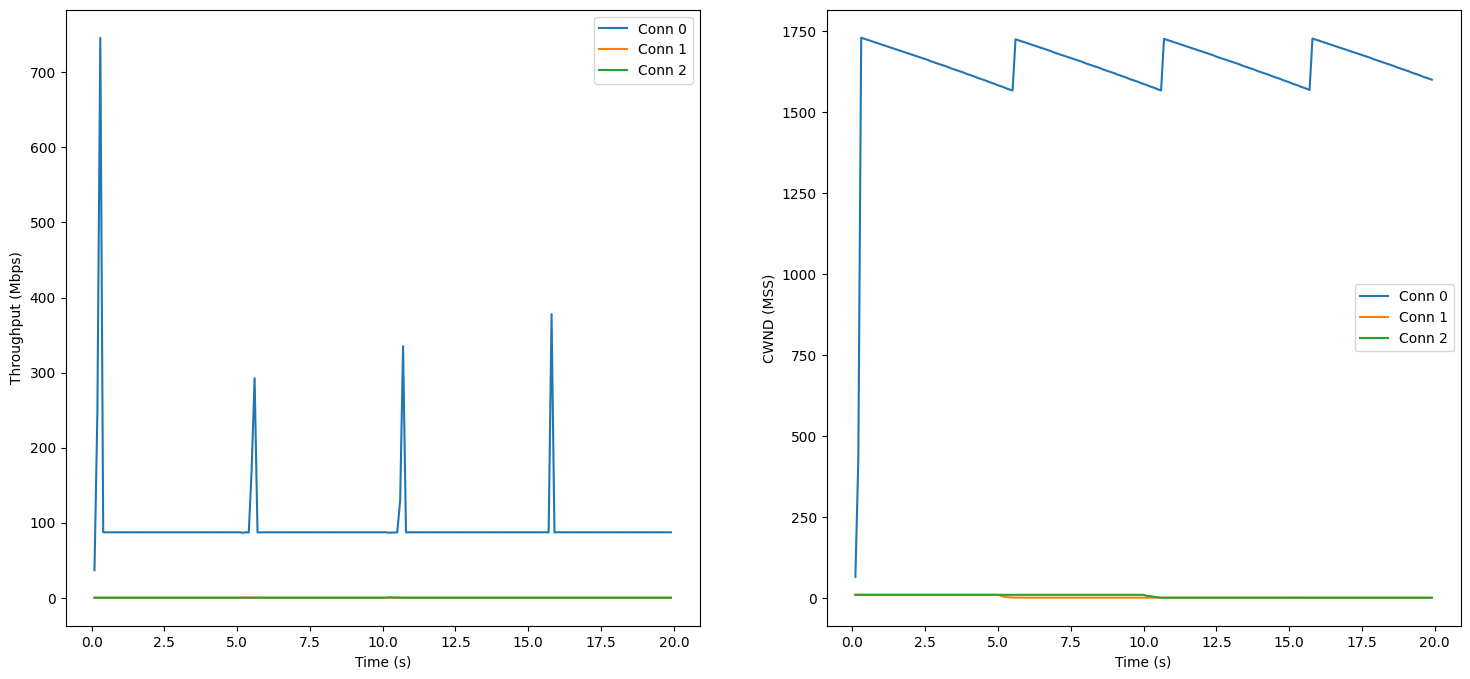

In [26]:
# Deseneaza graficele pentru throughput is cwnd. Figsize poate fi modificat pentru a schimba dimensiunea figurilor.
fig, axs = plt.subplots(ncols=2, figsize=(18, 8))

plot_throughput(axs[0], num_cons)
plot_cwnd(axs[1], num_cons)
plt.show()

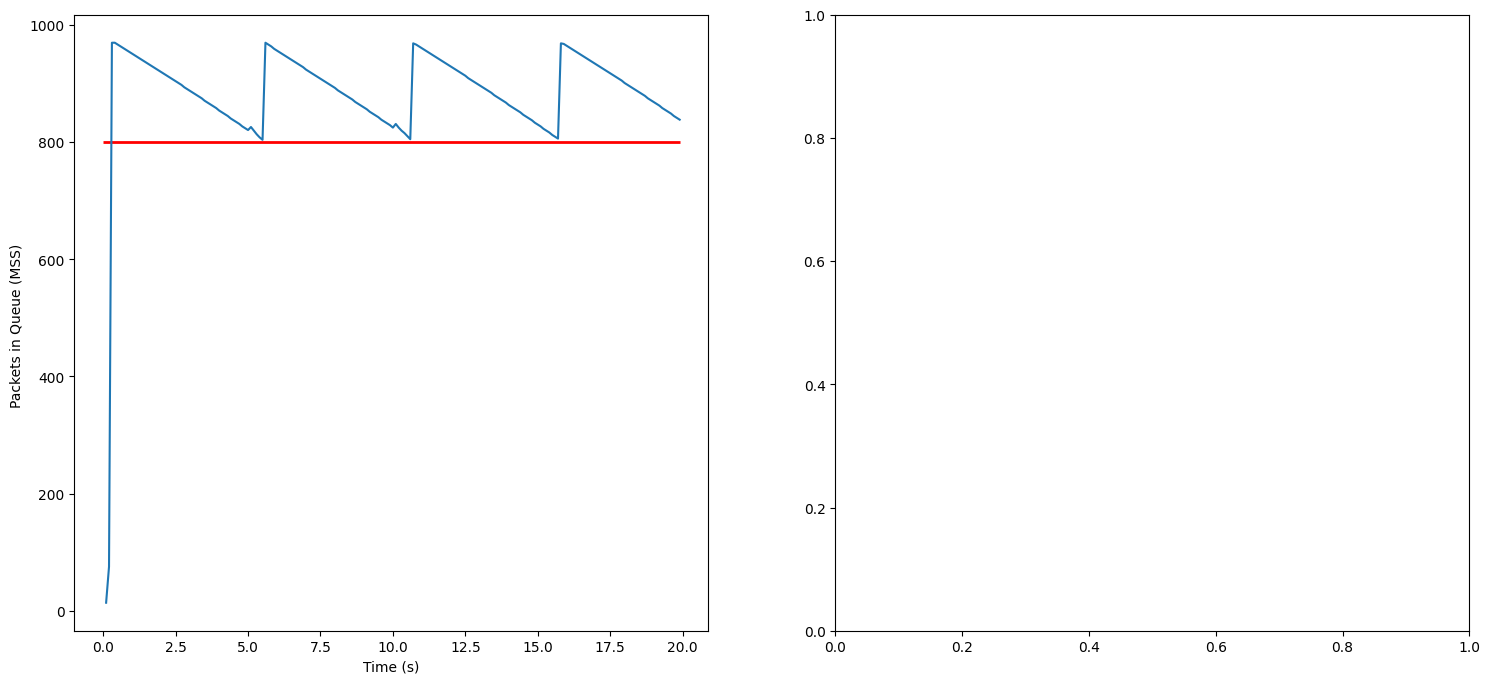

In [27]:
# Deseneaza dimensiunea cozii din router in MSS.
fig, axs = plt.subplots(ncols=2, figsize=(18, 8))

plot_router_queue(axs[0], router_queue_size)
plt.show()

## Masurarea performantei pentru clasamentul pe serie

Pentru a face distinctia intre implementari, vom acorda un scor de performanta algoritmului. Scorul este impartit in 3 categorii:

* thrghouput (300p)
* fairness (300p)
* latenta (300p)

In [28]:
# Functii helper folosite pentru a calcula valori precum average thrghouput
import math

# Calcuelaza average-ul dintr-o coloana dintr-un fisier .dat
def avg_col(data_path, col, scale):
        x1 = []
        with open(data_path) as f:
            for line in f:
                values = line.split()
                x1.append(float(values[col]) * scale)
        return sum(x1)/(len(x1))

# Afiseaza throughput-ul pentru o conexiune si traseazao linie orizontala la valoarea ideala.
def plot_throughput2(axs, data_path, bandwidth):
    axs.set_ylabel('Throughput (Mbps)')
    axs.set_xlabel('Time (s)')
    x1 = []
    y1 = []
    with open(data_path) as f:
        for line in f:
            values = line.split()
            x1.append(float(values[0]))
            y1.append(float(values[12]) * 8 / 1000000)
            
    axs.hlines(y=bandwidth, xmin=0, xmax=x1[-1], linewidth=2, color='r')
    # Ca sa arata graficul mai bine, nu luam in considerare primele 4 tick-uri
    axs.plot(x1[4:], y1[4:], '-')
    
# Afiseaza throughput-ul dintr-un anumit folder .dat
def plot_throughput_from_data(axs, num_cons, data_folder):
    axs.set_ylabel('Throughput (Mbps)')
    axs.set_xlabel('Time (s)')
    # Valorile din fisieri sunt in byes asa ca le inmultim cu 8/1000000 ca sa trecem in Mb/s
    plot_generic(axs, 0, 12, 'Throughput', 'Time (s)', 8 / 1000000, num_cons, data_folder)

### Throughput (Viteza de transmisie)
Ne intereseaza sa avem un averge thrghouput = BDP. Asta inseamna ca ar trebui sa ajungem 


no_of_conns 1
endtime(ms) 20000
Log interval set to 100ms
Queue size set to 166
Latency set to 0.1
Bandwidth set to 10Mbps
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
..........|..........|..........|......
##### [RESULT] Average thrghouput 9.59035175879394 vs 10 expected
no_of_conns 1
endtime(ms) 20000
Log interval set to 100ms
Queue size set to 16666
Latency set to 1
Bandwidth set to 100Mbps
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
..........|..........|..........|......
##### [RESULT] Average thrghouput 95.89266331658278 vs 100 expected
no_of_conns 1
endtime(ms) 20000
Log interval set to 100ms
Queue size set to 1666666
Latency set to 10
Bandwidth set to 1000Mbps
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
..........|..........|..........|......
##### [RESULT] Average thrghouput 937.969447236182 vs 1000 expected
+++++ Scorul pentru aceasta categorie: 285.59312562814

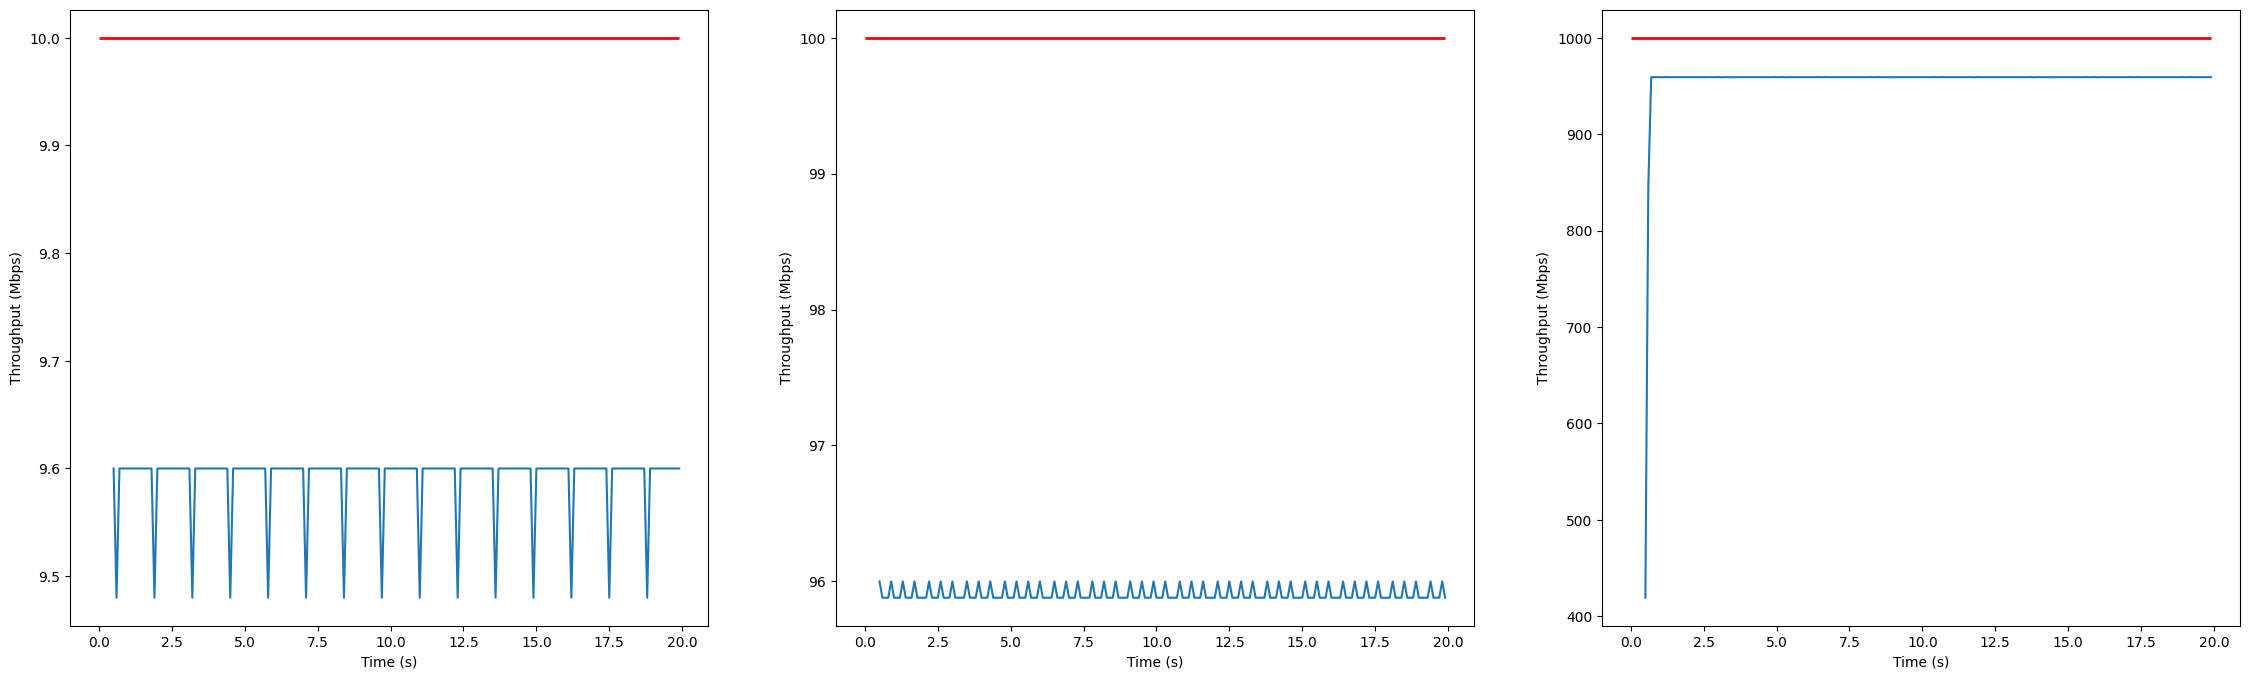

In [29]:
# Urmatoarele trei verifica daca algoritmul de congestie foloseste banda intr-un mod optim

# Vom masura rata de transmisie in diferite combinatii de throughput si latency. Coada de pachete din router are dimensiunea BDP-ului.
MSS = 1500 # in bytes
latency = [0.1, 1, 10] # ms
bandwidth = [10, 100, 1000] # Mbs
bdp = [ (i * j * 2 ) for i, j in zip(latency, bandwidth)]
queue_size_in_mss = [ int(i * 1000000 / (1500 * 8)) for i in bdp]
avg = []

# Rulam pentru trei scenarii diferite
for i in range(3):
    data_folder = "tmp/thr{}/".format(i)
    # Creeaza directorul in care vom salva rezultatele simularii
    !mkdir -p {data_folder}
    ! ./htsim_dumbell_cc -conns 1 -end 20000 -log 100 -q {queue_size_in_mss[i]} \
         -latency {latency[i]} -bandwidth {bandwidth[i]}; ./scripts/parse.sh logout.dat {data_folder}
    avg.append(avg_col("tmp/thr{}/0.dat".format(i), 12, 8 / 1000000))
    print("\n##### [RESULT] Average thrghouput {} vs {} expected".format(avg[i], bandwidth[i]))

# Calculeaza scorul pentru clasament. Acesta este media la cat am reusit sa acoperim din bandwidth in cele 3 scenarii.
score_thrghouput = (avg[0]/bandwidth[0] + avg[1]/ bandwidth[1] + avg[2]/ bandwidth[2]) * 100
print("+++++ Scorul pentru aceasta categorie: {} puncte".format(score_thrghouput))

# Deseneaza graficele thrghouput-ului. Linia orizontala rosie reprezinta valoarea asteptata.
fig, axs = plt.subplots(ncols=3, figsize=(28, 8))
for i in range(3):
    plot_throughput2(axs[i], "tmp/thr{}/0.dat".format(i), bandwidth[i])
plt.show()


## Fairness

Vrem ca banda sa fie impartita corect intre mai multe conexiuni.

no_of_conns 4
endtime(ms) 80000
Log interval set to 100ms
Queue size set to 800
Latency set to 5
Start delta to 500ms
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
.Start flow CCsrc 1 at 0.5s
Start flow CCsrc 2 at 1s
.Start flow CCsrc 3 at 1.5s
........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|.....
####### Min/Max average thrghouput: 0.0015018773466833543/93.59789737171482
no_of_conns 8
endtime(ms) 80000
Log interval set to 100ms
Queue size set to 800
Latency set to 2
Start delta to 500ms
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
.Start flow CCsrc 1 at 0.5s
Start flow CCsrc 2 at 1s
.Start flow CCsrc 3 at 1.5s
.Start flow CCsrc 4 at 2s
.Start flow CCsrc 5 at 2.5s
.Start flow CCsrc 6 at 3s
.Start flow CCsrc 7 at 3.5s
....|..........|..........|..........|..........|..........|..........|..........|..........|.

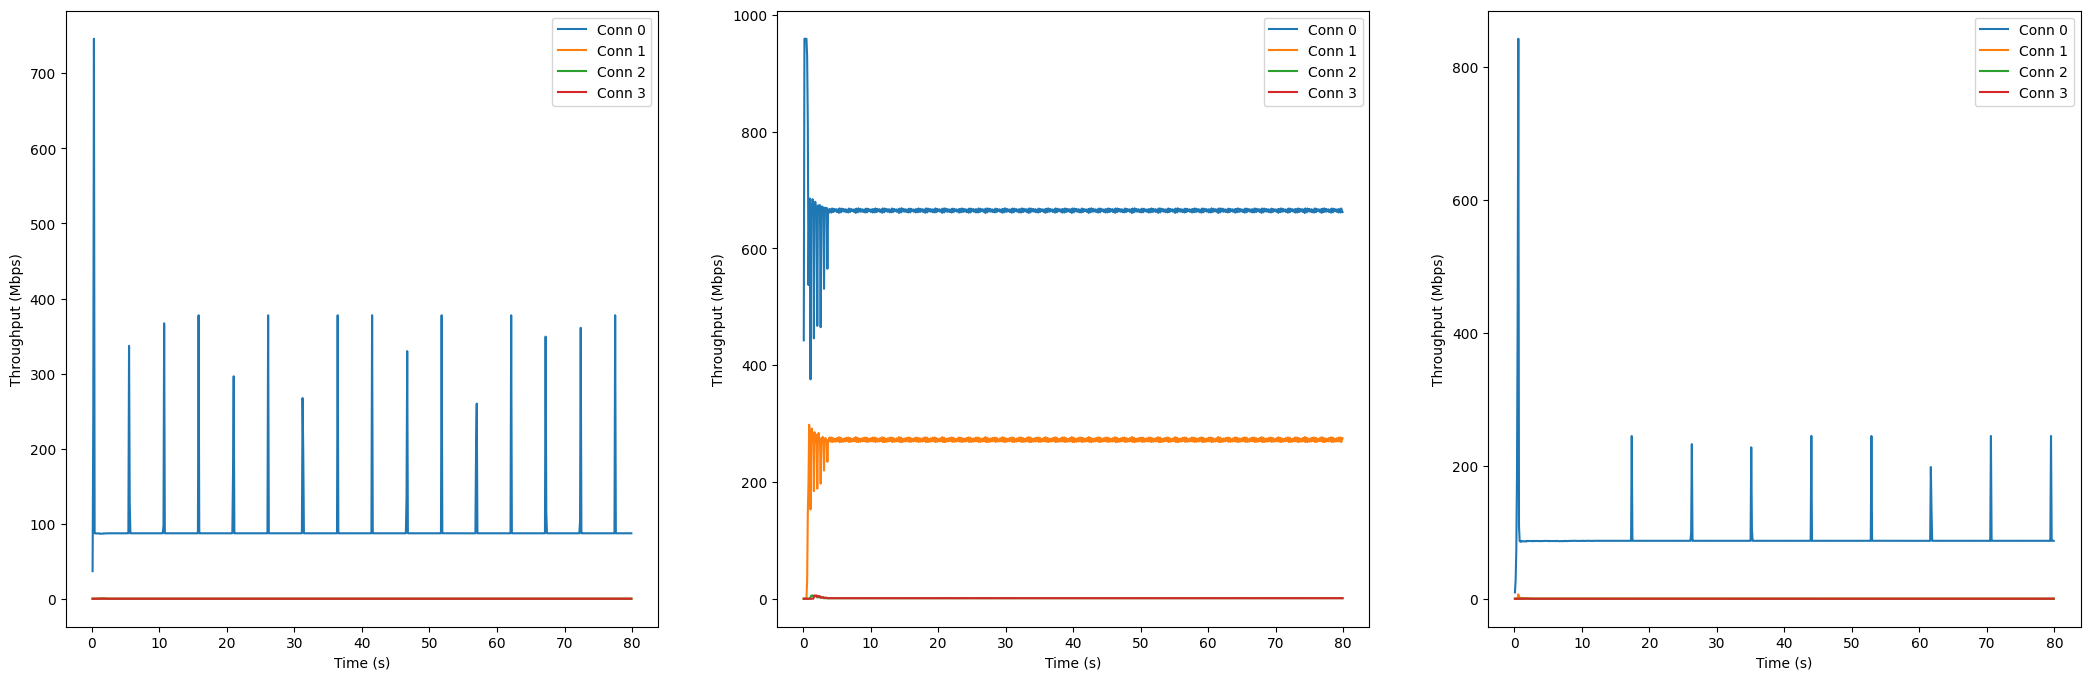

In [30]:
# Urmatorul experiment verifica daca algoritmul imparte in mod egal banda intre mai multe conexiuni.
num_cons = [4, 8, 16]
# In MSS
router_queue_size = 800
latency = [5, 2, 10]
fairness = []

# Rulam pentru trei scenarii diferite
for i in range(3):
    data_folder = "tmp/fair{}/".format(i)
    !mkdir -p data_folder
    # Ruleaza experimentul cu num_cons[i] conexiuni.
    ! ./htsim_dumbell_cc -conns {num_cons[i]} -end 80000 -log 100 -q {router_queue_size} -latency {latency[i]} \
    -startdelta 500; ./scripts/parse.sh logout.dat {data_folder}
    
    # Calculeaza raportul dintre throughput-ul cel mai mic al uneia dintre conexiuni cu cel mai mare. Ideal acesta ar trebui sa fie 1 pentru ca bandwidth-ul se imparte egal intre toate conexiunile
    avgs = []
    for j in range(num_cons[i]):
        # 8/10000000 pentru a trece in Mbps
        avgs.append(avg_col("tmp/fair{}/{}.dat".format(i, j), 12, 8 / 1000000))

    fairness.append(min(avgs)/max(avgs))
    print("\n####### Min/Max average thrghouput: {}/{}".format(min(avgs), max(avgs)))

score_fairness = (fairness[0] + fairness[1] + fairness[2]) / 3 * 100 * 3
print("+++++ Scorul pentru aceasta categorie: {} puncte".format(score_fairness))

# Deseneaza thoughput-ul pentru conexiuni. Din figsize putem schimba dimensiunea figurilor.
fig, axs = plt.subplots(ncols=3, figsize=(26, 8))
for i in range(3):
    plot_throughput_from_data(axs[i], 4, "tmp/fair{}/".format(i))
plt.show()

## Latenta


Vom masura latenta in functie de cat de incarcata este coada din router. Astfel, punctajul este acordat in functie de gradul de umplere al cozii.

no_of_conns 2
endtime(ms) 60000
Log interval set to 100ms
Queue size set to 16660
Start delta to 200ms
Latency set to 1
Bandwidth set to 10Mbps
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
Start flow CCsrc 1 at 0.2s
..........|..........|..........|..........|..........|..........|..........|..........|..........|..........|.........no_of_conns 4
endtime(ms) 60000
Log interval set to 100ms
Queue size set to 83330
Start delta to 200ms
Latency set to 1
Bandwidth set to 50Mbps
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 init 
Start flow CCsrc 0 at 0s
Start flow CCsrc 1 at 0.2s
Start flow CCsrc 2 at 0.4s
.Start flow CCsrc 3 at 0.6s
.........|..........|..........|..........|..........|..........|..........|..........|..........|..........|.........no_of_conns 3
endtime(ms) 60000
Log interval set to 100ms
Queue size set to 166660
Start delta to 200ms
Latency set to 1
Bandwidth set to 100Mbps
Outputting to logout.dat
CCSinkLoggerSampling(p=0.1 in

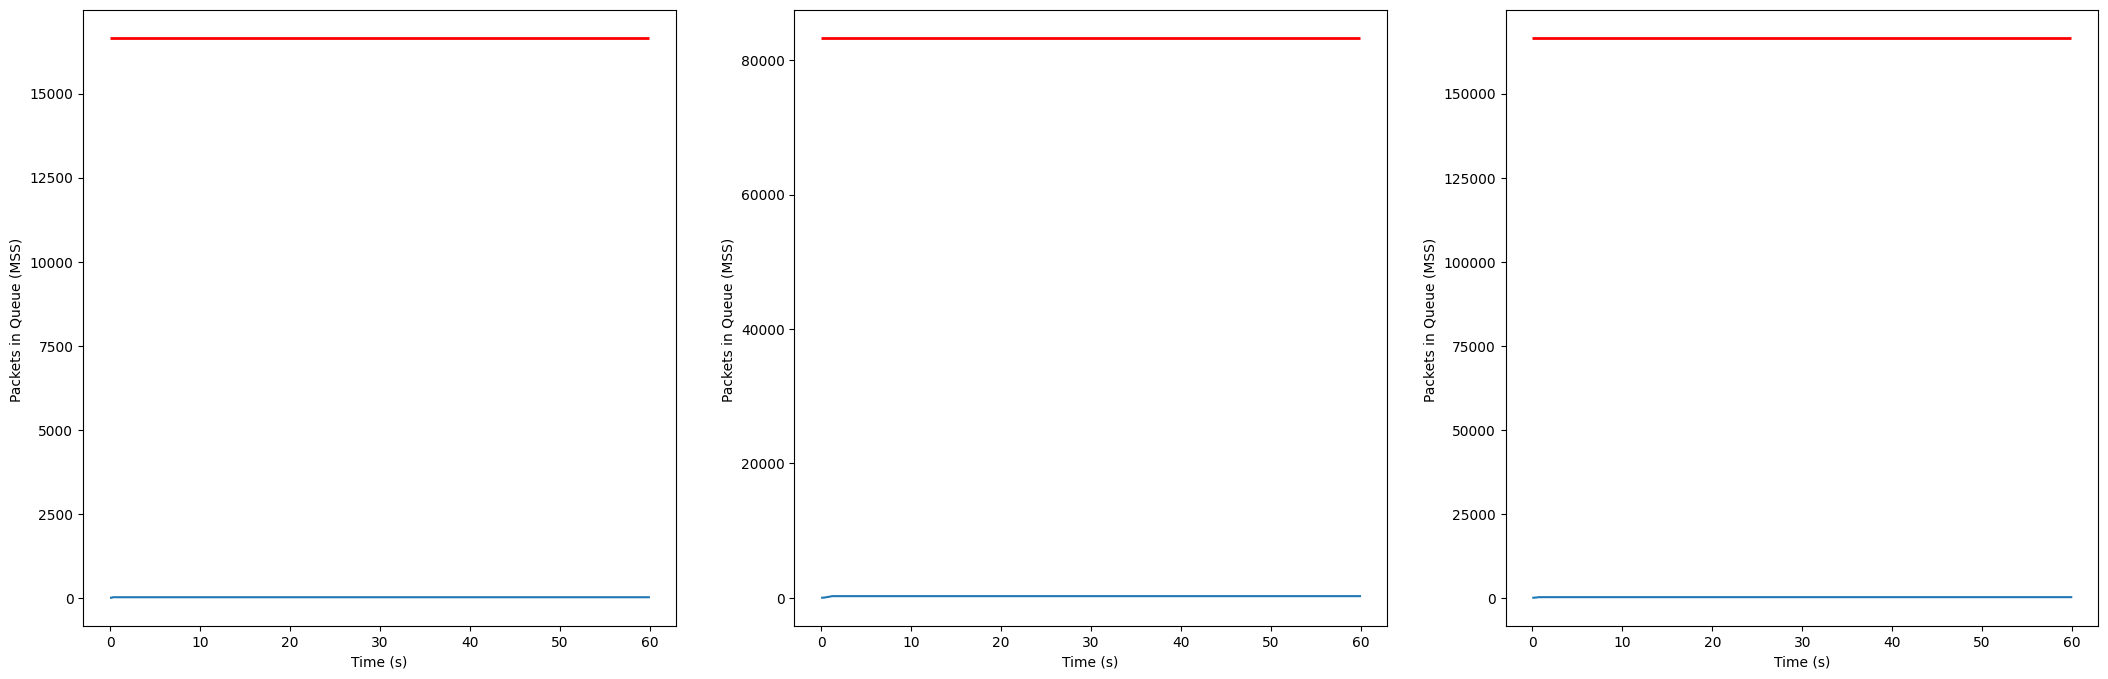

In [31]:
# Acest experiment masoara latenta per pachet introdusa de algoritmul de congestion control. Cu cat avem o coada mai mare de pachete ce asteapta la router
# cu atat latenta va creste.

MSS = 1500 # in bytes
latency = [1, 1, 1] # ms
bandwidth = [10, 50, 100] # Mbs
bdp = [ (i * j * 2 ) for i, j in zip(latency, bandwidth)]
# Coada din router o sa aiba 10 BDP
queue_size_in_mss = [ int(i * 1000000 / (MSS * 8)) * 10 for i in bdp]
num_cons = [2, 4, 3]
avgs = []

# Rulam pentru trei scenarii diferite
for i in range(3):
    data_folder = "tmp/lat{}/".format(i)
    !mkdir -p {data_folder}
    ! ./htsim_dumbell_cc -conns {num_cons[i]} -end 60000 -log 100 -q {queue_size_in_mss[i]} -startdelta 200 \
        -latency {latency[i]} -bandwidth {bandwidth[i]}; ./scripts/parse.sh logout.dat {data_folder}
    # Inmultim coloana 12 (numarul de bytes in buffer-ul routerului) cu1/1500 pentru ca vrem sa masuram in MSS (1500 de bytes)
    avgs.append(avg_col("tmp/lat{}/q.dat".format(i), 12, 1/1500))

score_latency = 300 - (avgs[0] / queue_size_in_mss[0] * 100 + avgs[1] / queue_size_in_mss[1] * 100 + avgs[2] / queue_size_in_mss[2] * 100)
print("\n+++++ Scorul pentru aceasta categorie: {} puncte".format(score_latency))

# Deseneaza numarul de pachete in coada. Linia orizontala reprezinta dimensiunea maxima in MSS a cozii ruterului.
fig, axs = plt.subplots(ncols=3, figsize=(26, 8))
for i in range(3):
    plot_router_queue(axs[i], queue_size_in_mss[i], "tmp/lat{}/".format(i))
plt.show()

# Evlauarea proiectului

Coordonatorul de echipa va incarca arhiva rezultata in urma rularii `create_archive.sh` pe Moodle. Arhiva va include un fisier `team.secret` cu ID-ul secret pe care
l-ati pus la inscriere si un writeup in format pdf. Nota finala la proiect va fi calculata la final in functie de pozitia in clasament si rezultatele la cele trei categorii.

In [32]:
scor_total = score_thrghouput + score_fairness + score_latency
print("Scor total {}/900".format(scor_total))

Scor total 585.1677730352545/900
